# XGBoost

Vamos a ver qué tal funciona el XGBoost con el problema de la predicción de acciones en bolsa.

### 1. Predicción del valor de acciones en bolsa

Nos vamos a conectar a la API de Yahoo Stocks para descargarnos los últimos 20 años de datos de la cotización en bolsa de Tesla e intentar predecir valores futuros.

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [2]:
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

dataset_raw = pdr.get_data_yahoo("TSLA", start="2000-01-01", end="2024-04-20")
dataset_raw.head()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [3]:
# Nos quedamos con la variable 'Close' unicamente
dataframe = dataset_raw[['Close']]
dataframe.head()

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [4]:
# utilizamos la función create_dataset que NO introduce T 0's iniciales
def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

# cargamos los datos
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# dividimos en train y test
# train_size = int(len(dataset) * 0.67)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# transformamos los datos para crearnos N registros con T timestamps cada uno
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y
# las V variables de las que disponga nuestro dataset. En este caso, vamos a
# escoger una ventana con un único timestamp T=10 y solo tendremos una variable,
# con lo que V=1 (valor de cierre de la acción).
look_back_memory = 10
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(2317, 10) (2317,)
(1137, 10) (1137,)


In [7]:
# entrenamos el modelo con los datos de entrenamiento
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainY)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform([trainPredict])[0]
trainY_orig = scaler.inverse_transform([trainY])[0]
testPredict = scaler.inverse_transform([testPredict])[0]
testY_orig = scaler.inverse_transform([testY])[0]

# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.29 RMSE
Test Score: 196.37 RMSE


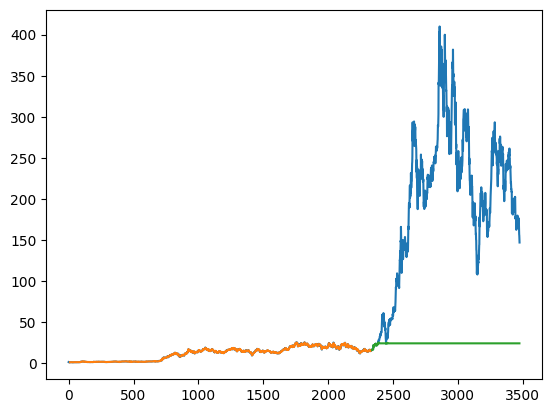

In [9]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty(dataset.shape[0])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory] = trainPredict

# y lo mismo para el test
testPredictPlot = numpy.empty(dataset.shape[0])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1] = testPredict

# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Entrenar usando un Walk-Forward Validation

In [10]:
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

dataset_raw = pdr.get_data_yahoo("TSLA", start="2000-01-01", end="2024-04-20")
dataset_raw.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [11]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

def create_dataset(dataset, look_back_memory=1):
    data = []
    for i in range(len(dataset)-look_back_memory):
        data.append(dataset[i:i+look_back_memory+1, 0])
    return numpy.array(data)

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in tqdm(range(len(test))):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX, n_estimators)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		# print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [12]:
# creamos el dataset como de costumbre
data = create_dataset(dataset_raw[['Close']].values, look_back_memory=10)
print(data.shape)

(3466, 11)


100%|██████████| 1760/1760 [01:19<00:00, 22.27it/s]


MAE: 5.897


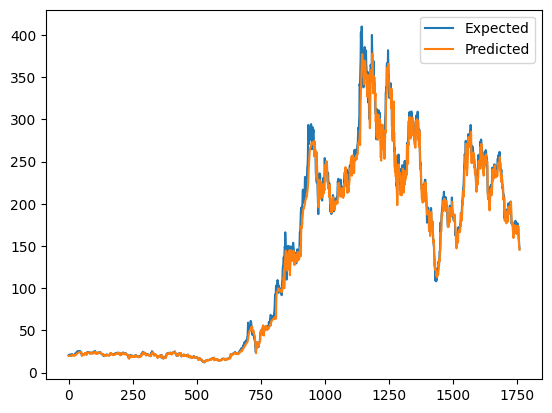

In [13]:
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=1760, n_estimators=10)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

100%|██████████| 1760/1760 [06:01<00:00,  4.87it/s]


MAE: 5.270


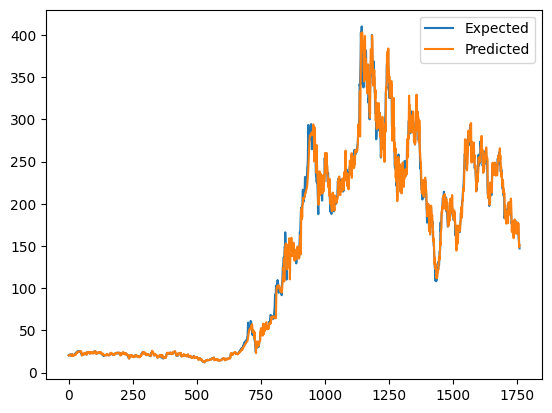

In [14]:
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=1760, n_estimators=100)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

Como podéis observar, la red es capaz de predecir bastante mejor los valores de cierre cuando utilizamos una número más elevado de estimadores.

Sin embargo, esto puede resultar en overfitting a menudo, así que hay que tener cuidado.

¿Cómo podíarmos mejorar estos resultados?

¿Y si utilizamos, además del valor de cierre, el resto de valores?

### Predicción con más de una variable

En esta ocasión utilizaremos todos los datos que nos brinda la API de Yahoo para predecir el precio de cierre de una acción.

In [15]:
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

dataset_raw = pdr.get_data_yahoo("TSLA", start="2000-01-01", end="2024-04-20")
dataset_raw.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [16]:
# vamos a dejar la columna "Close" la última
dataset_raw = dataset_raw[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]
dataset_raw.head()

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500,1.592667
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500,1.588667
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000,1.464000
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000,1.280000
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500,1.074000


In [17]:
def create_dataset(dataset):
    data = []
    for i in range(len(dataset)-1):
        data.append(np.append(dataset_raw.values[i, :-1], dataset_raw.values[i+1, -1]))
    return np.array(data)

data = create_dataset(dataset_raw.values)
print(data[:5])
print(data.shape)

[[1.26666701e+00 1.66666698e+00 1.16933298e+00 1.59266698e+00
  2.81494500e+08 1.58866704e+00]
 [1.71933305e+00 2.02800012e+00 1.55333304e+00 1.58866704e+00
  2.57806500e+08 1.46399999e+00]
 [1.66666698e+00 1.72800004e+00 1.35133302e+00 1.46399999e+00
  1.23282000e+08 1.27999997e+00]
 [1.53333294e+00 1.53999996e+00 1.24733305e+00 1.27999997e+00
  7.70970000e+07 1.07400000e+00]
 [1.33333302e+00 1.33333302e+00 1.05533302e+00 1.07400000e+00
  1.03003500e+08 1.05333304e+00]]
(3475, 6)


In [18]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0], model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
    predictions = list()
    models = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgboost_forecast(history, testX, n_estimators)
        # store forecast in list of predictions
        predictions.append(yhat)
        models.append(model)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, models

100%|██████████| 1760/1760 [00:54<00:00, 32.15it/s]


MAE: 6.354


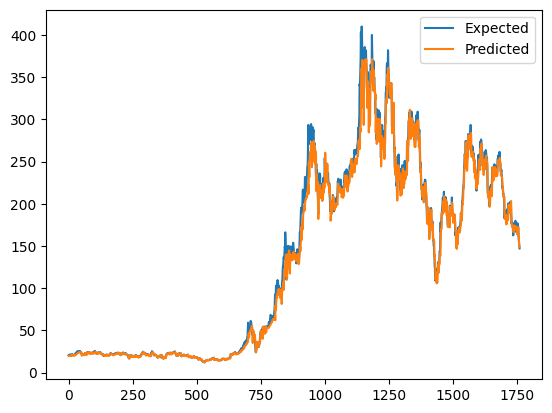

In [19]:
# evaluate
mae, y, yhat, models = walk_forward_validation(data, n_test=1760, n_estimators=10)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

Obtenemos un error muy similar a cuando utilizamos solo el valor de cierre (Close), incluso superior. ¿A qué puede deberse esto?

Fijaos:

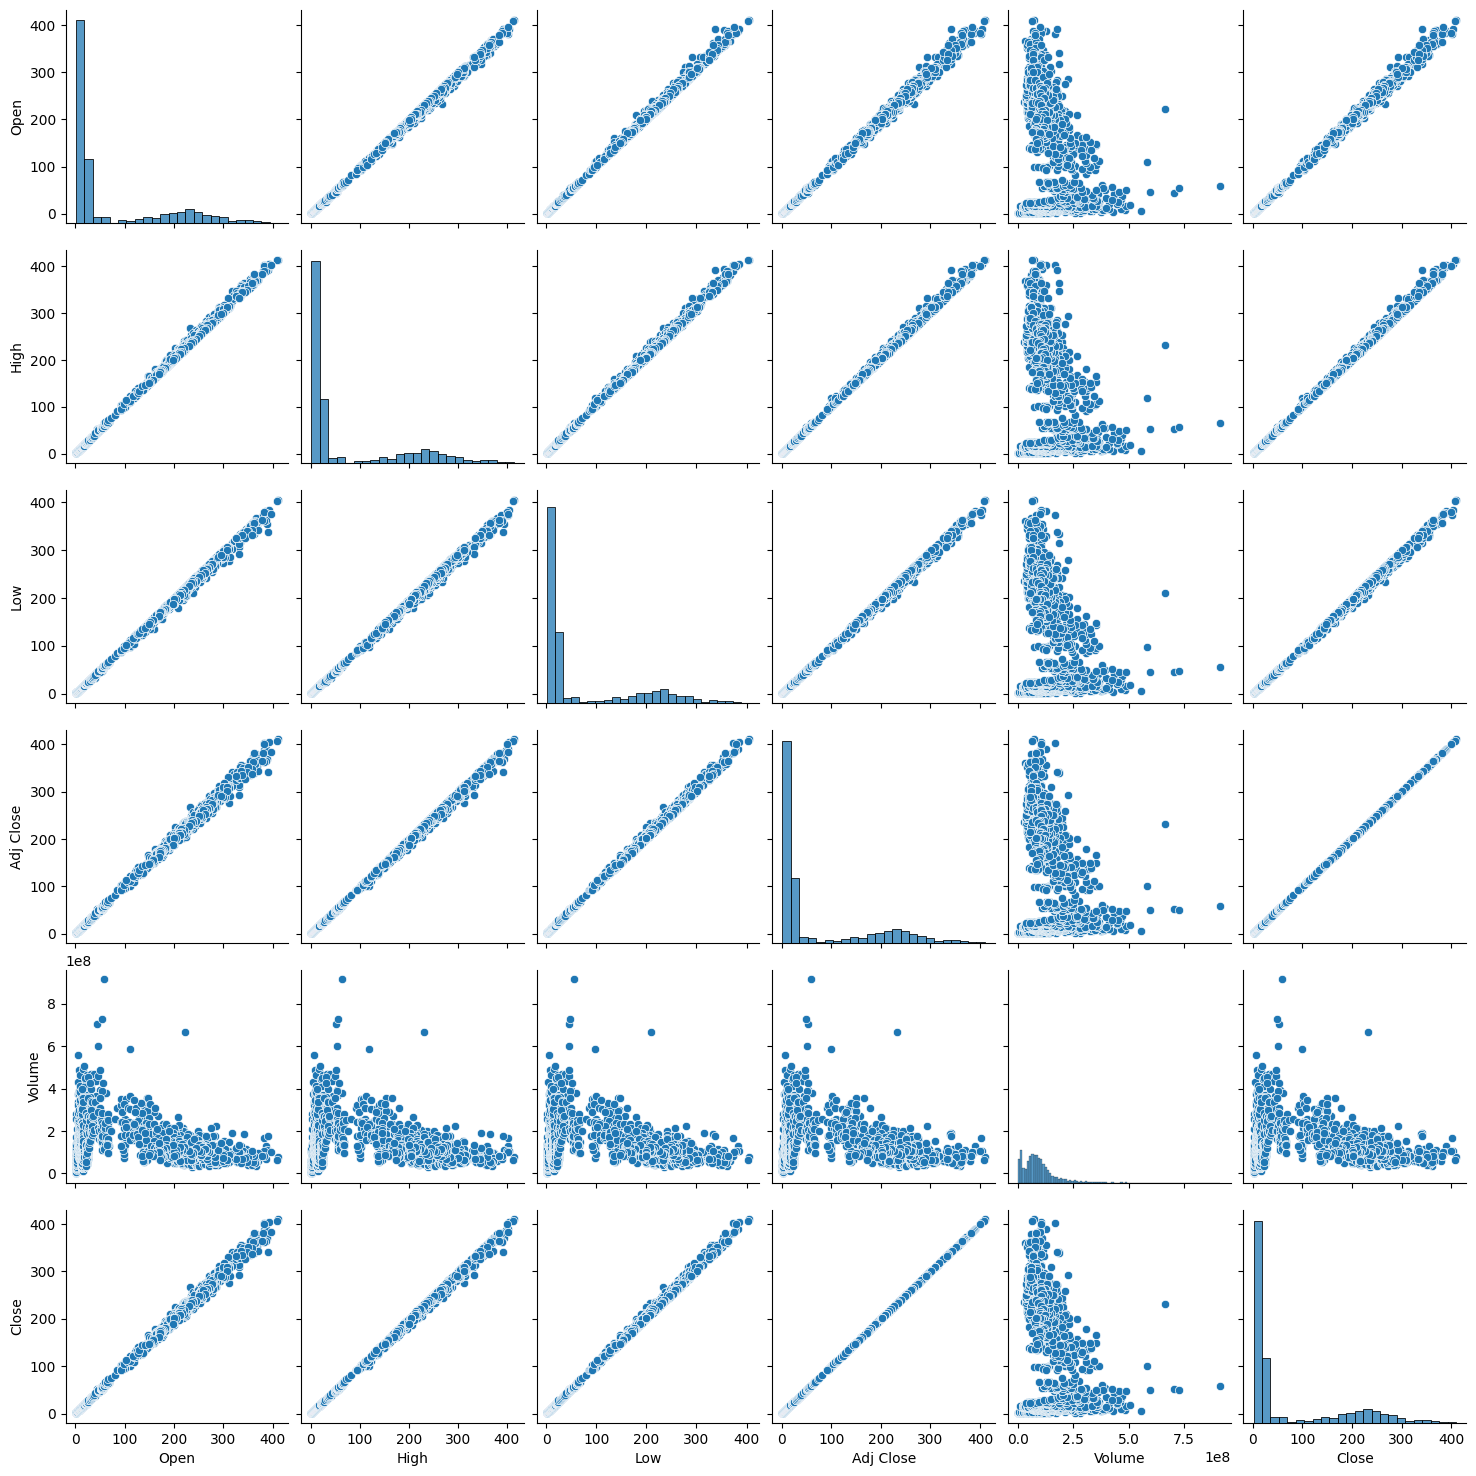

In [20]:
import seaborn as sns
sns.pairplot(dataset_raw)

Como podéis comprobar, las variables están muy correlacionadas entre sí, por lo que es normal que no aporten información al modelo.

Además, según con el modelo con el que trabajemos, podría incluso infuir negativamente.

Veamos la importancia de las variables obtenida por el XGBoost:

In [21]:
cols = dataset_raw.columns[:-1]
imps = numpy.stack([m.feature_importances_ for m in models])

In [22]:
imps.shape

(1760, 5)

In [23]:
feature_importances = DataFrame(imps, columns=cols)
# feature_importances = feature_importances.sort_values(by='imp',ascending=False)
# px.bar(feature_importances,x='col',y='imp')
feature_importances.describe()

,Open,High,Low,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,0.121827,0.303476,0.291629,0.282862,0.000207
std,0.162382,0.281853,0.261010,0.216622,0.000191
min,0.000265,0.002077,0.000806,0.009690,0.000059
25%,0.015828,0.060780,0.043249,0.075875,0.000105
50%,0.043017,0.197849,0.226894,0.241240,0.000138
75%,0.170796,0.497105,0.506700,0.453660,0.000213
max,0.870754,0.939997,0.945203,0.931816,0.001990


Las variables High, Low, Close y Open tienen una importancia muy similar. Viendo las correlaciones, esto nos indica que son redundantes. Por otra parte, Volume no aporta nada.

**¿Y si hubiéramos normalizado?**

In [24]:
def create_dataset(dataset):
    data = []
    for i in range(len(dataset)-1):
        data.append(numpy.append(dataset_raw.values[i, :-1], dataset_raw.values[i+1, -1]))
    return numpy.array(data)

data = create_dataset(dataset_raw.values)
print(data[:5])
print(data.shape)

[[1.26666701e+00 1.66666698e+00 1.16933298e+00 1.59266698e+00
  2.81494500e+08 1.58866704e+00]
 [1.71933305e+00 2.02800012e+00 1.55333304e+00 1.58866704e+00
  2.57806500e+08 1.46399999e+00]
 [1.66666698e+00 1.72800004e+00 1.35133302e+00 1.46399999e+00
  1.23282000e+08 1.27999997e+00]
 [1.53333294e+00 1.53999996e+00 1.24733305e+00 1.27999997e+00
  7.70970000e+07 1.07400000e+00]
 [1.33333302e+00 1.33333302e+00 1.05533302e+00 1.07400000e+00
  1.03003500e+08 1.05333304e+00]]
(3475, 6)


In [25]:
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data[:5]

array([[4.64595078e-04, 1.34982138e-03, 4.21743216e-04, 1.31893362e-03,
        3.06604867e-01, 1.30915180e-03],
       [1.56759864e-03, 2.22389882e-03, 1.37066943e-03, 1.30915180e-03,
        2.80639852e-01, 1.00428027e-03],
       [1.43926814e-03, 1.49818819e-03, 8.71494730e-04, 1.00428027e-03,
        1.33184151e-01, 5.54310805e-04],
       [1.11437537e-03, 1.04340943e-03, 6.14493991e-04, 5.54310805e-04,
        8.25596059e-02, 5.05407544e-05],
       [6.27038990e-04, 5.43474885e-04, 1.40030885e-04, 5.05407544e-05,
        1.10956375e-01, 0.00000000e+00]])

In [26]:
data.min(axis=0)

array([0., 0., 0., 0., 0., 0.])

In [27]:
data.max(axis=0)

array([1., 1., 1., 1., 1., 1.])

In [28]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy
from tqdm import tqdm

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX, n_estimators):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0], model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_estimators=10):
    predictions = list()
    models = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, model = xgboost_forecast(history, testX, n_estimators)
        # store forecast in list of predictions
        predictions.append(yhat)
        models.append(model)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, models

100%|██████████| 1760/1760 [00:46<00:00, 38.02it/s]


MAE: 0.016


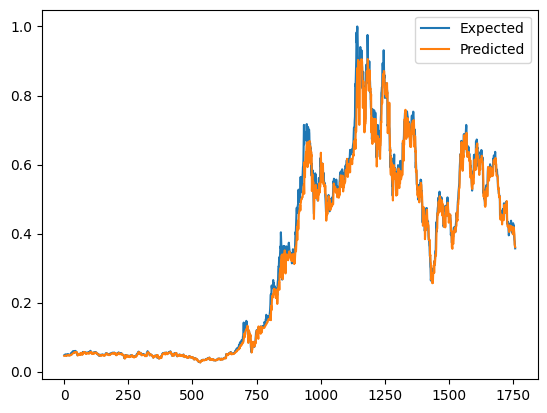

In [29]:
# evaluate
mae, y, yhat, models = walk_forward_validation(data, n_test=1760, n_estimators=10)
print('MAE: %.3f' % mae)

# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [30]:
cols = dataset_raw.columns[:-1]
imps = numpy.stack([m.feature_importances_ for m in models])

In [31]:
feature_importances = DataFrame(imps, columns=cols)
feature_importances.describe()

,Open,High,Low,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,0.126742,0.307488,0.290285,0.275263,0.000223
std,0.165267,0.282872,0.259110,0.212359,0.000199
min,0.000266,0.003471,0.000884,0.009617,0.000059
25%,0.018128,0.063055,0.043380,0.072040,0.000115
50%,0.048224,0.201655,0.232648,0.232835,0.000148
75%,0.177673,0.507535,0.506428,0.447591,0.000239
max,0.866178,0.950104,0.944858,0.914602,0.001988


Fijaos que el ajuste es mejor, pero sigue sin tener en cuenta la variable Volume para nada.

**Más ejemplos interesantes de predicción con XGBoost**

- Predicción de compras

https://www.kaggle.com/alessandrosolbiati/using-xgboost-for-time-series-prediction-top-20

- Nacimientos de niñas

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

- Consumo de energía eléctrica

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

https://github.com/Jenniferz28/Time-Series-ARIMA-XGBOOST-RNN

- Predicción de la demanda de bicicletas:

https://towardsdatascience.com/go-highly-accurate-or-go-home-61828afb0b13

**Más datasets**

https://archive.ics.uci.edu/ml/index.php

